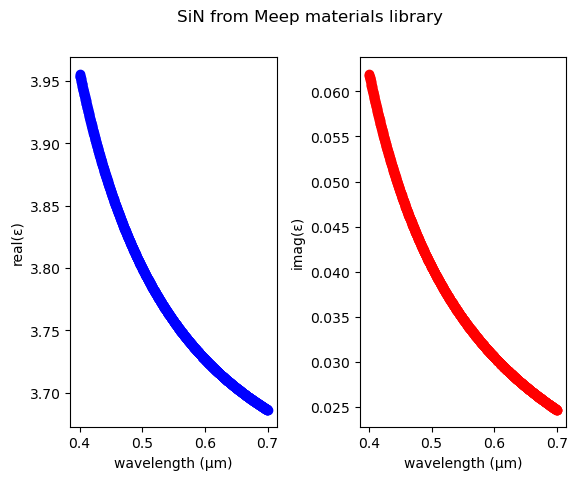

In [1]:
import meep as mp
import meep.adjoint as mpa
from meep.materials import SiN
import numpy as np
import matplotlib.pyplot as plt

um_scale = 2
resolution = 20

wvl_min = 0.4 # units of μm
wvl_max = 0.7 # units of μm
nwvls = 1000
wvls = np.linspace(wvl_min, wvl_max, nwvls)

SiN_epsilon = np.array([SiN.epsilon(1/w)[0][0] for w in wvls])

plt.subplot(1,2,1)
plt.plot(wvls,np.real(SiN_epsilon),'bo-')
plt.xlabel('wavelength (μm)')
plt.ylabel('real(ε)')

plt.subplot(1,2,2)
plt.plot(wvls,np.imag(SiN_epsilon),'ro-')
plt.xlabel('wavelength (μm)')
plt.ylabel('imag(ε)')

plt.suptitle('SiN from Meep materials library')
plt.subplots_adjust(wspace=0.4)
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-06 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 20
time for set_epsilon = 0.02072 s
time for set_conductivity = 0.000663996 s
time for set_conductivity = 0.000663996 s
time for set_conductivity = 0.00067997 s
time for set_conductivity = 0.000731945 s
time for set_conductivity = 0.000715971 s
time for set_conductivity = 0.00072217 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------
Meep: using complex fields.
field decay(t = 2.025): 1.472689613549383e-113 / 1.472689613549383e-113 = 1.0
field decay(t = 3.0500000000000003): 1.4718710863679556e-44 / 1.4718710863679556e-44 = 1.0
field decay(t = 4.05): 2.1831779674676016e-25 / 2.1831779674676016e-25 = 1.0
field decay(t = 5.075): 2.1056529360966857e-19 / 2.1056529360966857e-19 = 1.0
field decay(t = 6.1000000000000005): 4.07834664982837e-11 / 4.07834664982837e-11 = 1.0
field decay(t = 7.125): 5.976484092526075e

/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/simulation.py:1652: RuntimeWarning: Note: your sources include frequencies outside the range of validity of the material models. This is fine as long as you eventually only look at outputs (fluxes, resonant modes, etc.) at valid frequencies.
  warnings.warn(warn_src, RuntimeWarning)


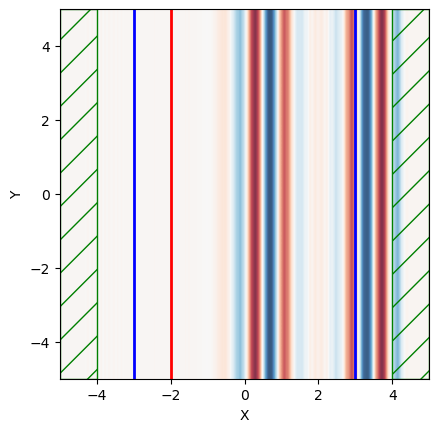

In [2]:
# SiN = mp.Medium(index=2)

pml_layers = [mp.Absorber(thickness=1, direction = mp.X)]
# pml_layers = [mp.PML(thickness=1)]
cell_size = mp.Vector3(10,10)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = (1/(0.40 * um_scale) - 1/(0.70 * um_scale))
nfreq = 100

src = mp.GaussianSource(fcen, df, is_integrated=True)

sources = [mp.Source(src, component=mp.Ez, size=mp.Vector3(y=10), center=mp.Vector3(-2))]





geometry=[]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiN],
                    k_point=mp.Vector3(0,5,0))

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-3, 0, 0), size=mp.Vector3(0, 10, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(3, 0, 0), size=mp.Vector3(0, 10, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



pt = mp.Vector3(4, 8, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_fields_decayed(1,mp.Ez,pt,1e-5))

plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [3]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

In [4]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 9.05991e-06 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 20
     block, center = (2,0,0)
          size (4,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)
time for set_epsilon = 0.034426 s
time for set_conductivity = 0.00107598 s
time for set_conductivity = 0.00110698 s
time for set_conductivity = 0.00108504 s
time for set_conductivity = 0.00110888 s
time for set_conductivity = 0.00110412 s
time for set_conductivity = 0.00109005 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------
Meep: using complex fields.
field decay(t = 2.025): 7.539654241781936e-114 / 7.539654241781936e-114 = 1.0
field decay(t = 3.0500000000000003): 5.441561111920024e-45 / 5.441561111920024e-45 = 1.0
field decay(t = 4.05): 8.961066015313408e-26 / 8.961066015313408e-26 = 1.0
field decay(t = 5.075): 9.383144162644705e-20 / 9.3831

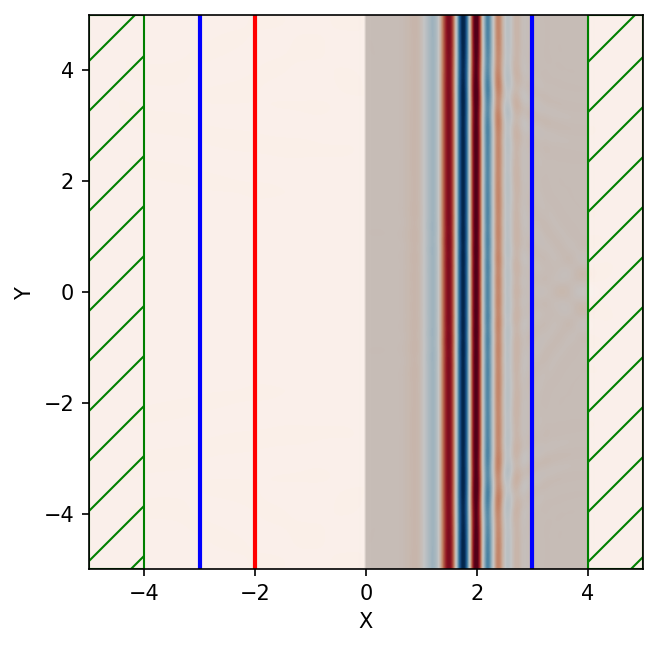

In [5]:
geometry = [mp.Block(
        mp.Vector3(4, 10, 0),
        center=mp.Vector3(2,0),
        material=SiN
    )]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiN],
                    k_point=mp.Vector3(0,5,0)
                    )

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(4, 8, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_fields_decayed(1,mp.Ez,pt,1e-5))
# sim.run(until=16)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

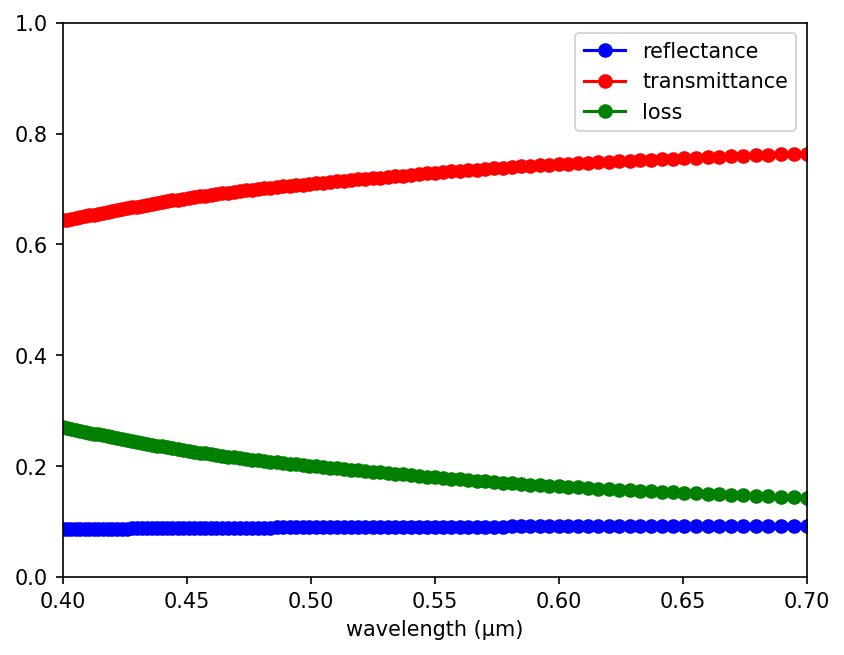

In [6]:
wl = [] #resolution 50
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

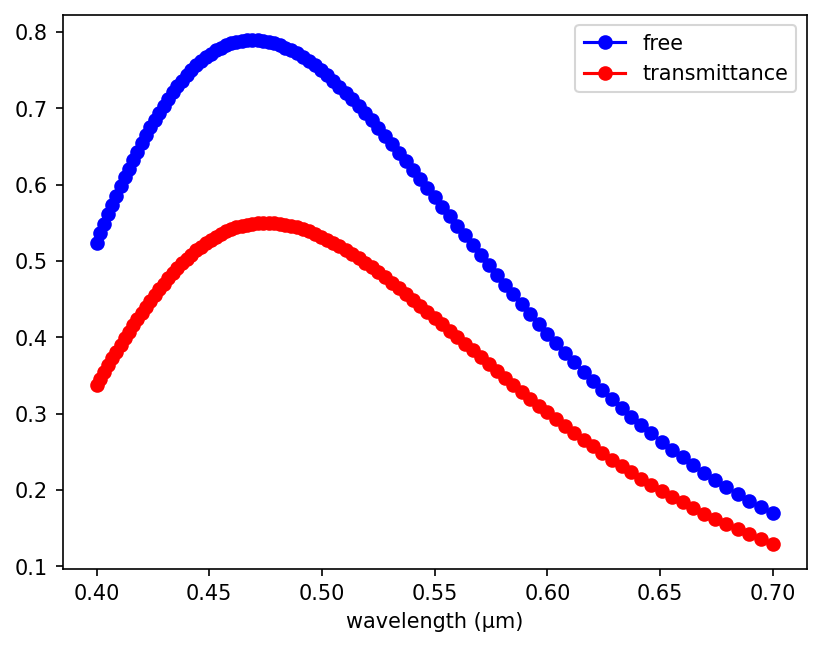

In [7]:
wl = [] #resolution 50
Rst = []
Tst = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rst = np.append(Rst, straight_tran_flux[i])
    Tst = np.append(Tst, bend_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rst, "bo-", label="free")
    plt.plot(wl, Tst, "ro-", label="transmittance")
    # plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

In [8]:
np.savetxt("Reflection_my_code.txt",Rs)
np.savetxt("Transmission_my_code.txt",Ts)